In [87]:
# basics
import pandas as pd
import numpy as np
import math

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# regression
import statsmodels.formula.api as sm
import statsmodels.stats.api as sms
from scipy.stats import f_oneway
from scipy import stats
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import linear_harvey_collier

# other prediction methods
from sklearn import datasets
from sklearn import svm
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC

# evalutiation
import statsmodels.tools.eval_measures as smem
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.metrics import (brier_score_loss, precision_score, recall_score,
                             f1_score)
from sklearn.model_selection import cross_validate, cross_val_score, train_test_split

In [2]:
cRange = ['#475468', '#e7e6e6', '#4b73be', '#df8244', '#a5a5a5', '#f7c143',
          '#20406a', '#deeef8', '#2d6fc0', '#409cd4', '#5ccdd7', '#5ecb9e',
          '#a53218', '#c59933', '#f08a40', '#aa4f30', '#f7bf5d', '#d85733',
          '#728083', '#8babb4', '#7196ad', '#607397', '#8585c2', '#a687c1']
colors = ['#475468', '#e7e6e6', '#4b73be', 
          '#df8244', '#a5a5a5', '#f7c143'] 
cmapOffice = mpl.colors.ListedColormap([cRange[i] for i in range(0, 5)])
cmapBlue = mpl.colors.ListedColormap([cRange[i] for i in range(6, 11)])
cmapRed = mpl.colors.ListedColormap([cRange[i] for i in range(12, 17)])
cmapViolett = mpl.colors.ListedColormap([cRange[i] for i in range(18, 23)])

In [113]:
data = pd.read_csv("../00_data/data_with_calc_fields.csv", sep=";", decimal=",", index_col="datetime")
data.index = pd.to_datetime(data.index)
data = data[["price_diff", "hour", "season", "month", "weekday", "total_generation_forecast", "forecast_error", "day_ahead_price", "intraday_price"]]

## Feature selection

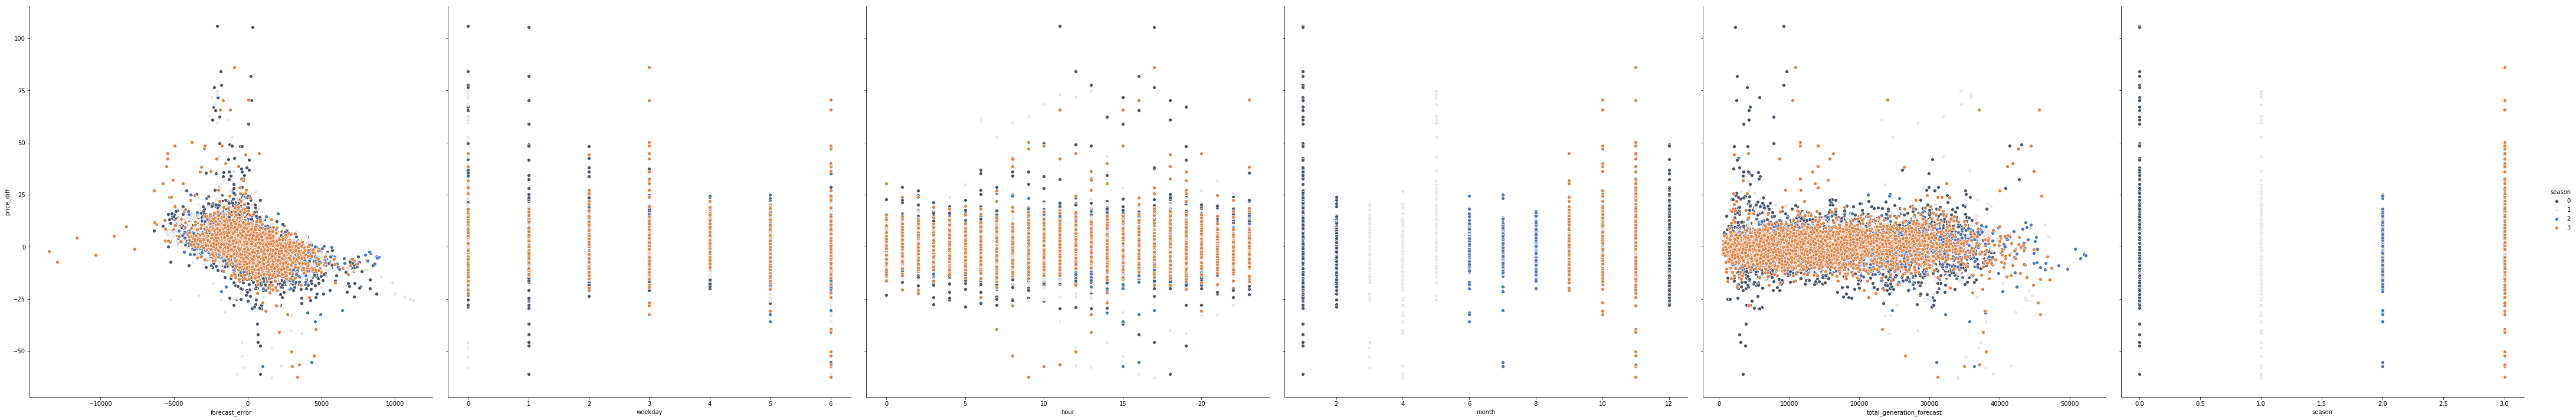

In [4]:
# visualize the relationship between the features and the response using scatterplots
sns.pairplot(data, x_vars=["forecast_error", "weekday", "hour", "month", "total_generation_forecast", "season"], y_vars=["price_diff"], height=10, hue="season", palette=colors)

C:\Users\Tabea\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


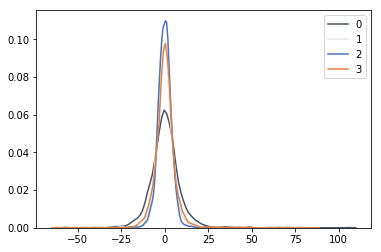

In [5]:
for w in range(4):
    sns.kdeplot(data[(data.season==w)].price_diff, label=w, color=colors[w])

### => Forecast error, season and total generation forecast could be useful

## Test multiple forecast methods

Create a holdout set for later testing of the methods. Try to predict price_diff value or class positive/negative for positive or negative price_diff

In [103]:
X = data[["forecast_error", "season", "hour", "total_generation_forecast"]]
X = X.reset_index()
X = X.drop("datetime", axis=1)
X.head(3)

y = data["price_diff"]

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.3)
y2_train = (y_train>=0).astype('int')
y2_test = (y_test>=0).astype('int')

for df in [X_train, y_train, y2_train, X_test, y_test, y2_test]:
    df.sort_index(inplace=True)

C:\Users\Tabea\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [65]:
# Dict containing the scorers to be used
scoring = {'explained_variance': 'explained_variance',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_median_absolute_error': 'neg_median_absolute_error',
           'r2': 'r2'
          }

# Function to convert the list of dicts to a DataFrame and then print it
def print_scores(scores_list, param_range):
    scores_list = [{k:v.mean() for k,v in alpha.items()} for alpha in scores_list]
    scores_df = pd.DataFrame(scores_list, index=param_range).drop(["fit_time", "score_time"],axis=1)
    scores_df.columns=["expl_var",
                       "mean_abs_err",
                       "mean_sqrd_err",
                       "median_abs_err",
                       "r2"]
    scores_df["expl_var"] = scores_df["expl_var"].round(4)
    scores_df["mean_abs_err"] = scores_df["mean_abs_err"].abs().round(2)
    scores_df["mean_sqrd_err"] = scores_df["mean_sqrd_err"].abs().round(1)
    scores_df["median_abs_err"] = scores_df["median_abs_err"].abs().round(3)
    scores_df["r2"] = scores_df["r2"].round(4)
    return scores_df

# Dict containing the scorers to be used for classification
scoringBin = {'accuracy': 'accuracy',
           'neg_mean_absolute_error': 'neg_mean_absolute_error',
           'neg_mean_squared_error': 'neg_mean_squared_error',
           'neg_median_absolute_error': 'neg_median_absolute_error',
           'roc_auc': 'roc_auc',
           'precision': 'precision',
           'recall': 'recall'
          }

# Function to convert the list of dicts to a DataFrame and then print it for classification scores
def print_scores_bin(scores_list, param_range):
    scores_list = [{k:v.mean() for k,v in alpha.items()} for alpha in scores_list]
    scores_df = pd.DataFrame(scores_list, index=param_range).drop(["fit_time", "score_time"],axis=1)
    scores_df.columns=["accuracy",
                       "mean_abs_err",
                       "mean_sqrd_err",
                       "median_abs_err",
                       "roc_auc",
                       "precision", # fraction of pos. classifications that are actual positives
                       "recall"]    # fraction of actual positives that are classified as pos.
    scores_df["mean_abs_err"] = scores_df["mean_abs_err"].abs().round(2)
    scores_df["mean_sqrd_err"] = scores_df["mean_sqrd_err"].abs().round(1)
    scores_df["median_abs_err"] = scores_df["median_abs_err"].abs().round(3)
    scores_df["roc_auc"] = scores_df["roc_auc"].round(4)
    scores_df["accuracy"] = scores_df["accuracy"].round(4)
    scores_df["precision"] = scores_df["precision"].round(4)
    scores_df["recall"] = scores_df["recall"].round(4)
    return scores_df

### Option 1: Predict price diff value

In [83]:
# Method: Regression
def prepareDataForRegression(X):
    dummies = pd.get_dummies(X["season"]).iloc[:,:-1]
    seasons = ["winter", "spring", "summer"]
    dummies.columns = dummies.columns.map(lambda x: seasons[x])
    X2 = X.drop(columns=["season", "hour"], axis=1)
    X2 = X2.join(dummies)
    X2.forecast_error.astype('float')
    X2.total_generation_forecast.astype('float')
    return X2

scores_list = []
param_range = range(1)
reg = linear_model.LinearRegression()
X2 = prepareDataForRegression(X_train)
score = cross_validate(reg, X2, y_train, scoring=scoring, return_train_score=False, n_jobs=-1)
scores_list.append(score)
display(print_scores(scores_list, param_range))

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
0,0.1821,3.76,38.8,2.616,0.1814


In [10]:
# Method: Decision Tree Regression
param_range = range(1,5)
scores_list = []
for i in param_range:
    DTR = DecisionTreeRegressor(max_depth=i)
    scores_list.append(cross_validate(DTR, X_train, y_train, scoring=scoring, return_train_score=False, n_jobs=-1))
display(print_scores(scores_list, param_range))

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
1,0.1093,4.00,39.7,2.903,0.1080
2,0.1633,3.83,37.3,2.724,0.1612
3,0.1754,3.78,36.6,2.695,0.1735
4,0.1640,3.81,37.4,2.686,0.1612


In [11]:
# Method: Random Forest Regression
param_range = range(1,10)
scores_list = []
for i in param_range:
    RTR = RandomForestRegressor(max_depth=i)
    score = cross_validate(RTR, X_train, y_train, scoring=scoring, return_train_score=False, n_jobs=-1)
    scores_list.append(score)
display(print_scores(scores_list, param_range))

,expl_var,mean_abs_err,mean_sqrd_err,median_abs_err,r2
1,0.1360,3.91,38.7,2.777,0.1343
2,0.1890,3.75,36.3,2.649,0.1866
3,0.1959,3.72,35.9,2.641,0.1930
4,0.1855,3.75,36.5,2.621,0.1823
5,0.1782,3.76,37.0,2.615,0.1766
6,0.1727,3.75,37.0,2.604,0.1713
7,0.1378,3.80,38.3,2.611,0.1360
8,0.1274,3.80,38.4,2.617,0.1262
9,0.1228,3.83,38.6,2.632,0.1220


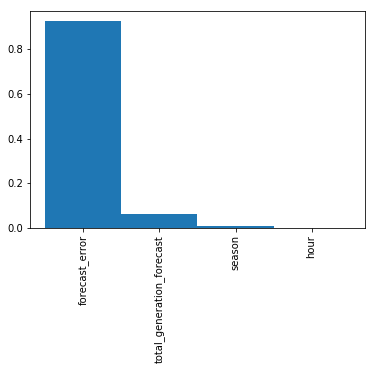

[(0.9266, 'forecast_error'),
 (0.0634, 'total_generation_forecast'),
 (0.0099, 'season'),
 (0.0, 'hour')]

In [12]:
# Influence of features
RFR = RandomForestRegressor(max_depth=3)
RFR.fit(X_train,y_train)
features = sorted(zip(map(lambda x: round(x, 4), RFR.feature_importances_), X_train.columns), reverse=True)
ys, labels = zip(*features)
xs = np.arange(len(labels)) 
width = 1
plt.bar(xs, ys, width, align='center')
plt.xticks(xs, labels, rotation='vertical')
plt.show()
features[0:8]

### Option 2: Predict price diff class

In [75]:
# Method: Decision Tree Classfier
param_range = range(1,5)
scores_list = []
for i in param_range:
    DTR = DecisionTreeClassifier(max_depth=i)
    scores_list.append(cross_validate(DTR, X_train, y2_train, scoring=scoringBin, return_train_score=False, n_jobs=-1))
display(print_scores_bin(scores_list, param_range))

,accuracy,mean_abs_err,mean_sqrd_err,median_abs_err,roc_auc,precision,recall
1,0.6756,0.32,0.3,0.0,0.6685,0.6911,0.6757
2,0.6756,0.32,0.3,0.0,0.6685,0.6911,0.7262
3,0.6756,0.32,0.3,0.0,0.6685,0.6911,0.7363
4,0.6720,0.33,0.3,0.0,0.6835,0.6523,0.7380


In [74]:
# Method: Logistic Regression
logReg = linear_model.LogisticRegression()
scores_list = []
param_range = range(1)
scores_list.append(cross_validate(logReg, X_train, y2_train, scoring=scoringBin, return_train_score=False, n_jobs=-1))
print_scores_bin(scores_list, param_range)

,accuracy,mean_abs_err,mean_sqrd_err,median_abs_err,roc_auc,precision,recall
0,0.6747,0.33,0.3,0.0,0.6692,0.686,0.7457


In [73]:
# Method: Support Vector Machine
svm = LinearSVC(random_state=0)
scores_list = []
param_range = range(1)

scores_list.append(cross_validate(svm, X_train, y2_train, scoring=scoringBin, return_train_score=False, n_jobs=-1))
print_scores_bin(scores_list, param_range)

,accuracy,mean_abs_err,mean_sqrd_err,median_abs_err,roc_auc,precision,recall
0,0.5035,0.5,0.5,0.333,0.5945,0.6739,0.5616


In [76]:
# Method: Naive Bayes
scores_list = []
param_range = range(1)

nb = GaussianNB()
scores_list.append(cross_validate(nb, X_train, y2_train, scoring=scoringBin, return_train_score=False, n_jobs=-1))
print_scores_bin(scores_list, param_range)

,accuracy,mean_abs_err,mean_sqrd_err,median_abs_err,roc_auc,precision,recall
0,0.6738,0.33,0.3,0.0,0.6559,0.7248,0.7461


## Evaluation

### Prediction of price diff value

In [98]:
results = pd.DataFrame(index=range(1))

reg = linear_model.LinearRegression()
X2_train = prepareDataForRegression(X_train)
X2_test = prepareDataForRegression(X_test)
model = reg.fit(X2_train, y_train)
y_pred = model.predict(X2_test)
results["Reg."] = r2_score(y_test, y_pred)

RFR = RandomForestRegressor(max_depth=3)
model = RFR.fit(X_train, y_train)
y_pred = model.predict(X_test)
results["RFR"] = r2_score(y_test, y_pred)

DTR = DecisionTreeRegressor(max_depth=3)
model = DTR.fit(X_train, y_train)
y_pred = model.predict(X_test)
results["DTR"] = r2_score(y_test, y_pred)

results = results.transpose()
results.columns = ["score"]
display(results.sort_values("score", ascending=False))

,score
RFR,0.216875
DTR,0.205360
Reg.,0.205184


### Prediction of price diff sign

In [93]:
results = pd.DataFrame(index=range(1))

DTC = DecisionTreeClassifier(max_depth=3)
model = DTC.fit(X_train, y2_train)
y_pred = model.predict(X_test)
results["DTC"] = accuracy_score(y2_test, y_pred)

logReg = linear_model.LogisticRegression()
logReg.fit(X_train, y2_train)
y_pred = logReg.predict(X_test)
results["logReg"] = accuracy_score(y2_test, y_pred)

svm = LinearSVC(random_state=0)
svm.fit(X_train, y2_train)
y_pred = svm.predict(X_test)
results["SVM"] = accuracy_score(y2_test, y_pred)

nb = GaussianNB()
nb.fit(X_train, y2_train)
y_pred = nb.predict(X_test)
results["NB"] = accuracy_score(y2_test, y_pred)

results = results.transpose()
results.columns = ["score"]
display(results.sort_values("score", ascending=False))

,score
logReg,0.68155
NB,0.68136
DTC,0.67433
SVM,0.66445


In [147]:
def getCostsForDayAhead(data):
    return data.day_ahead_price.sum(axis=0)

def getCostsForIntraday(data):
    return data.intraday_price.sum(axis=0)

def getCostsForRandom(data):
    permutation = np.random.permutation(len(data))
    ind = permutation[:int(len(permutation)*0.5)]
    indIntraday = permutation[int(len(permutation)*0.5):]
    dayAhead = data.iloc[ind,:]
    intraday = data.iloc[indIntraday,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForCondProb(data):
    condProb = 0.66  # from other notebook
    pred = data["forecast_error"]
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_forecast_error"]
    pred.index = data.index
    merged = data_test.join(pred)
    intradayIndices = merged.loc[merged.pred_forecast_error<0,:].sample(frac=condProb).index.values
    dayAheadIndices = list(set(merged.index.values) - set(intradayIndices))
    intraday = merged.loc[intradayIndices]
    dayAhead = merged.loc[dayAheadIndices]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForLogRegression(X_train, y2_train, X_test, data_test):
    logReg = linear_model.LogisticRegression()
    logReg.fit(X_train, y2_train)
    y_pred = logReg.predict(X_test)
    pred = pd.DataFrame(y_pred)
    pred.columns = ["pred_price_diff"]
    pred.index = data_test.index
    merged = data_test.join(pred)
    intraday = merged.loc[merged.pred_price_diff==0,:]
    dayAhead = merged.loc[merged.pred_price_diff==1,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

def getCostsForRandomForest(X_train, y_train, X_test, data_test):
    RFR = RandomForestRegressor(max_depth=3)
    RFR.fit(X_train, y_train)
    pred = RFR.predict(X_test)
    pred = pd.DataFrame(pred)
    pred.columns = ["pred_price_diff"]
    pred.index = data_test.index
    merged = data_test.join(pred)
    intraday = merged.loc[merged.pred_price_diff<0,:]
    dayAhead = merged.loc[merged.pred_price_diff>=0,:]
    return (dayAhead.day_ahead_price.sum(axis=0)+intraday.intraday_price.sum(axis=0))

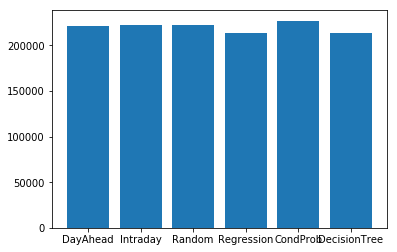

    DayAhead   Intraday     Random  Regression   CondProb  DecisionTree
0  221845.06  223578.01  222827.76   214262.35  228482.89     214211.23
1  223180.40  224706.29  223777.98   215792.11  228742.04     215711.56
2  220619.24  222058.11  221168.86   213284.26  226468.18     213314.20
3  222427.00  223842.17  223447.52   215047.93  228392.06     214965.54
4  220022.32  220254.73  220166.96   211868.14  225634.54     211899.93
5  221154.71  222211.63  221177.01   213413.24  226457.80     213441.26
6  220962.19  222952.07  221649.38   213438.17  226991.44     213414.69
7  221685.74  223260.46  222751.50   213984.70  227771.05     213930.14
8  220348.73  221672.19  221302.72   212625.81  226119.62     212750.00
9  221036.29  222339.67  222189.47   213210.31  226707.39     213305.09
F-Test to determine if methods produce costs of same distribution
230.38161489778508
4.010907131340708e-35
t-Test for Significance of difference between Day-ahead and regression
Ttest_indResult(statistic=16.1

C:\Users\Tabea\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


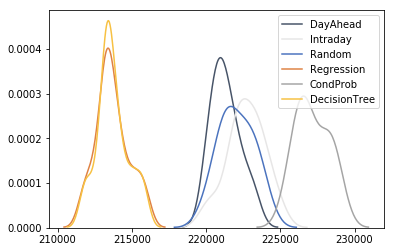

In [152]:
methods = ["DayAhead", "Intraday", "Random", "Regression", "CondProb", "RandomForest"]
df = pd.DataFrame(columns=methods)
for n in range(10):
    X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.4)
    y2_train = (y_train>=0).astype('int')
    y2_test = (y_test>=0).astype('int')
    data_test = data.iloc[X_test.index.values]
    res = []
    res.append(getCostsForDayAhead(data_test))
    res.append(getCostsForIntraday(data_test))
    res.append(getCostsForRandom(data_test))
    res.append(getCostsForLogRegression(X_train, y2_train, X_test, data_test))
    res.append(getCostsForCondProb(data_test))
    res.append(getCostsForRandomForest(X_train, y_train, X_test, data_test))
    df.loc[n] = res
plt.bar(df.columns.values, df.mean())
plt.show()
print(df)
for m in range(len(methods)):
    sns.kdeplot(df.iloc[:,m], color=colors[m])
print("F-Test to determine if methods produce costs of same distribution")
stat, p = f_oneway(df["DayAhead"], df["Intraday"], df["Random"], df["Regression"], df["CondProb"], df["RandomForest"])
print(stat)
print(p)
print("t-Test for Significance of difference between Day-ahead and regression")
print(stats.ttest_ind(df["DayAhead"], df["Regression"]))